## Simple example

In [ ]:
import numpy as np
import torch
from torch_geometric.utils import to_networkx
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import MetaPath2Vec, SAGEConv, to_hetero

### MetaPath2Vec embeddings

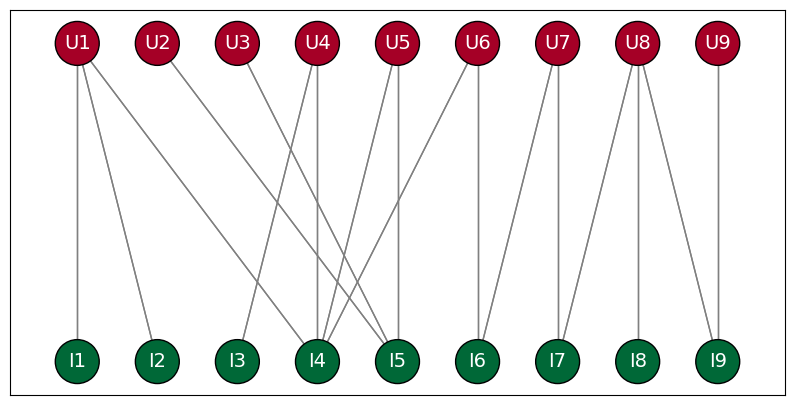

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F

data = HeteroData()
data['user', 'item'].edge_index = torch.tensor([
    [0, 0, 0, 1, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 7, 8],
    [0, 1, 3, 4, 4, 2, 3, 3, 4, 3, 5, 5, 6, 6, 7, 8, 8]
])
data['user'].num_nodes = 9
data['item'].num_nodes = 9
data = T.ToUndirected()(data)

users_labels_mapping = {i: f'U{i+1}' for i in range(data['user'].num_nodes)}
items_labels_mapping = {i + data['user'].num_nodes: f'I{i+1}' for i in range(data['item'].num_nodes)}
labels_mapping = dict(users_labels_mapping)
labels_mapping.update(items_labels_mapping)

graph = to_networkx(data)

ax = plt.figure(figsize=(10, 5)).add_subplot()
nx.draw_networkx(
    graph,
    pos=nx.bipartite_layout(graph,
                            nodes=np.arange(data['user'].num_nodes, data['user'].num_nodes+data['item'].num_nodes),
                            align='horizontal'),
    node_color=np.r_[np.ones(data['user'].num_nodes)*0.4, np.ones(data['item'].num_nodes )*0.6],
    cmap='RdYlGn',
    node_size=1000,
    edge_color='grey', arrows=False,
    labels=labels_mapping, font_color='white', font_size=14,
    edgecolors='black', linewidths=1,
    ax=ax,
    )

In [691]:
data

HeteroData(
  user={ num_nodes=9 },
  item={ num_nodes=9 },
  (user, to, item)={ edge_index=[2, 17] },
  (item, rev_to, user)={ edge_index=[2, 17] }
)

In [692]:
metapath = [
    ('user', 'to', 'item'),
    ('item', 'rev_to', 'user'),
]

mp2v = MetaPath2Vec(data.edge_index_dict, embedding_dim=2, walks_per_node=3,
                     metapath=metapath, walk_length=3, context_size=3)
loader = mp2v.loader(batch_size=5)
optimizer = torch.optim.Adam(list(mp2v.parameters()), lr=0.01)

In [693]:
for pos_rw, neg_rw in loader:
    print(f'{pos_rw[:5,:]=}')
    print(f'{neg_rw[:5,:]=}')
    break

pos_rw[:5,:]=tensor([[ 9,  1,  9],
        [10,  4, 10],
        [11,  4, 13],
        [12,  2, 12],
        [13,  3,  9]])
neg_rw[:5,:]=tensor([[ 9,  1, 15],
        [10,  8,  9],
        [11,  6, 12],
        [12,  5, 14],
        [13,  3, 14]])


In [694]:
def train():
    mp2v.train()
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = mp2v.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()

    return loss

for epoch in range(1, 1000):
    loss = train()
    if epoch % 100 == 0:
        print((f'Epoch: {epoch}, '
                f'Loss: {loss :.4f}'))

Epoch: 100, Loss: 1.2876
Epoch: 200, Loss: 1.0159
Epoch: 300, Loss: 0.9433
Epoch: 400, Loss: 0.9350
Epoch: 500, Loss: 1.0035
Epoch: 600, Loss: 1.0577
Epoch: 700, Loss: 1.0411
Epoch: 800, Loss: 0.9598
Epoch: 900, Loss: 1.2069


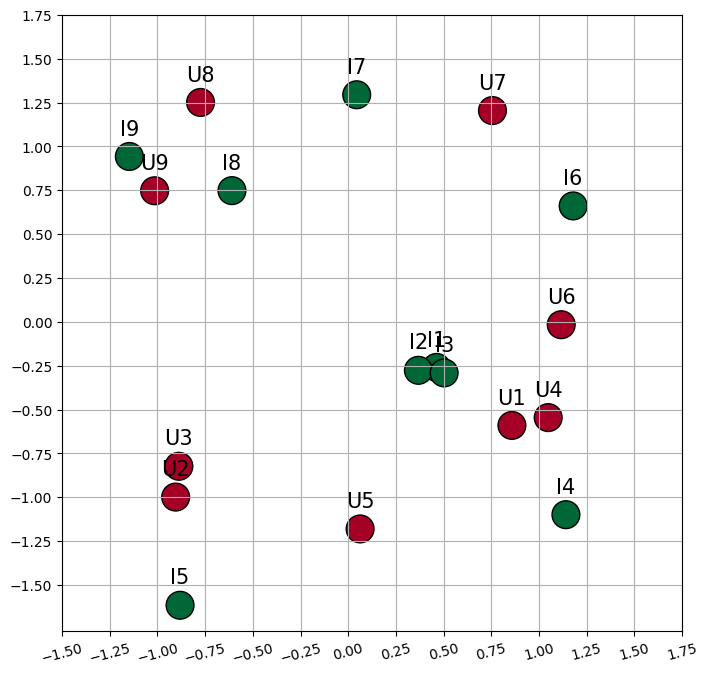

In [695]:
users_emb = mp2v.forward('user').detach().numpy()
items_emb = mp2v.forward('item').detach().numpy()

x_embs = np.r_[users_emb[:, 0], items_emb[:, 0]]
y_embs = np.r_[users_emb[:, 1], items_emb[:, 1]]
nodes_color = np.r_[np.ones(data['user'].num_nodes)*0.4, np.ones(data['item'].num_nodes)*0.6]

plt.figure(figsize=(8, 8))
plt.scatter(x=x_embs,
            y=y_embs,
            s=400,
            edgecolor='black', linewidth=1,
            c=nodes_color,
            cmap='RdYlGn',)

plt.xticks(np.arange(-1.5, 2, step=0.25), rotation=15)
plt.yticks(np.arange(-1.5, 2, step=0.25))
plt.grid(which='both')

for i, (x, y) in enumerate(zip(x_embs, y_embs)):
    plt.text(x, y+0.1, labels_mapping[i], fontdict={'size': 15}, va='bottom', ha='center')

In [702]:
data['user'].x = torch.tensor(users_emb)
data['item'].x = torch.tensor([
    [0., 0.],
    [0., .3],
    [.3, .3],
    [.5, .4],
    [.6, .7],
    [.7, .7],
    [.8, .8],
    [.9, .9],
    [1., 1.]
]
)

### GraphSage implementation

In [713]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), channels)
        self.conv2 = SAGEConv((-1, -1), channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * channels, channels)
        self.lin2 = torch.nn.Linear(channels, 1)

    def forward(self, x_dict, edge_label_index):
        users_edges, items_edges = edge_label_index
        x = torch.cat([x_dict['user'][users_edges], x_dict['item'][items_edges]], dim=1)

        z = self.lin1(x).relu()
        z = self.lin2(z).sigmoid()

        return z.view(-1)

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [718]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1, num_test=0.1,
    add_negative_train_samples=True, neg_sampling_ratio=1.,
    edge_types=[('user', 'to', 'item')],
    rev_edge_types=[('item', 'rev_to', 'user')],
)(data)

train_loader = LinkNeighborLoader(
    train_data,
    batch_size=20,
    num_neighbors=[5, 5],
    shuffle=True,
    edge_label_index=(('user', 'to', 'item'), train_data['user', 'item'].edge_label_index),
    edge_label=train_data['user', 'item'].edge_label
)

val_loader = LinkNeighborLoader(
    val_data,
    batch_size=20,
    num_neighbors=[5, 5],
    shuffle=True,
    edge_label_index=(('user', 'to', 'item'), val_data['user', 'item'].edge_label_index),
    edge_label=val_data['user', 'item'].edge_label
)

test_loader = LinkNeighborLoader(
    test_data,
    batch_size=20,
    num_neighbors=[5, 5],
    shuffle=True,
    edge_label_index=(('user', 'to', 'item'), test_data['user', 'item'].edge_label_index),
    edge_label=test_data['user', 'item'].edge_label
)

In [720]:
def train():
    gnn.train()
    total_examples = total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch_size = len(batch['user', 'item'].edge_label)

        out = gnn(batch.x_dict, batch.edge_index_dict, batch['user', 'item'].edge_label_index)
        target = batch['user', 'item'].edge_label
        loss = F.binary_cross_entropy(out, target)
        
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size
        
    return float(total_loss / total_examples)

@torch.no_grad()
def val():
    gnn.eval()
    total_examples = total_loss = 0

    for batch in val_loader:
        batch_size = len(batch['user', 'item'].edge_label)

        out = gnn(batch.x_dict, batch.edge_index_dict, batch['user', 'item'].edge_label_index)
        target = batch['user', 'item'].edge_label
        loss = F.binary_cross_entropy(out, target)

        total_examples += batch_size
        total_loss += float(loss) * batch_size
        
    return float(total_loss / total_examples)

gnn = GNN(hidden_channels=2)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01)

for epoch in range(1000):
    loss = train()
    if (epoch + 1) % 100 == 0:
        val_loss = val()
        print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, val_loss: {val_loss:.4f}')

Epoch: 0099, Loss: 0.5720, val_loss: 0.6542
Epoch: 0199, Loss: 0.5404, val_loss: 0.6885
Epoch: 0299, Loss: 0.5374, val_loss: 0.6927
Epoch: 0399, Loss: 0.5363, val_loss: 0.7051
Epoch: 0499, Loss: 0.5343, val_loss: 0.7099
Epoch: 0599, Loss: 0.5288, val_loss: 0.6993
Epoch: 0699, Loss: 0.5386, val_loss: 0.7061
Epoch: 0799, Loss: 0.5383, val_loss: 0.6935
Epoch: 0899, Loss: 0.5281, val_loss: 0.6931
Epoch: 0999, Loss: 0.5316, val_loss: 0.7033
